In [1]:
import torch
import numpy as np
import os 

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from src.train import estimate_mutual_information
from src.estimators import density_ratio_fitting_obj, probabilistic_classifier_obj, js_fgan_lower_bound_obj
import torch.optim as optim

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
audio_dim, textual_dim = 100, 100
batch_size = 512
estimator = 'probabilistic_classifier' # 'density_ratio_fitting' 'probabilistic_classifier' 'variational_f_js'


lr = 1e-3

relative_ratio = 0.001

hidden_dim=512 
embed_dim=128
layers=1
activation = 'relu'

In [4]:
# datassets are downloaded from 
# https://github.com/iamyuanchung/speech2vec-pretrained-vectors
audio_base_pth = '../../speech2vec-pretrained-vectors/speech2vec/'
textual_base_pth = '../../speech2vec-pretrained-vectors/word2vec/'

In [5]:
import torch.nn as nn
import torch.nn.functional as F
def mlp(dim, hidden_dim, output_dim, layers, activation):
    activation = {
        'relu': nn.ReLU,
        'tanh': nn.Tanh,
    }[activation]

    seq = [nn.Linear(dim, hidden_dim), activation()]
    for _ in range(layers):
        seq += [nn.Linear(hidden_dim, hidden_dim), activation()]
    seq += [nn.Linear(hidden_dim, output_dim)]

    return nn.Sequential(*seq)
class SeparableCritic(nn.Module):
    def __init__(self, audio_dim, textual_dim, hidden_dim, embed_dim, 
                 layers, activation):
        super(SeparableCritic, self).__init__()
        self._g = mlp(audio_dim, hidden_dim, embed_dim, layers, activation)
        self._h = mlp(textual_dim, hidden_dim, embed_dim, layers, activation)

    def transformed_x(self, x):
        return self._g(x)
    
    def transformed_y(self, y):
        return self._h(y)
    
    def forward(self, x, y):
        scores = torch.matmul(self._h(y), self._g(x).t())
        return scores
    
    def pointwise_mi(self, x, y, estimator):
        scores = torch.matmul(self._h(y), self._g(x).t())
        if estimator == 'density_ratio_fitting':
            relative_ratio_scores = torch.clamp(scores, min=1e-5, max=(1./relative_ratio)-1e-5).diag()
            ratio_scores = (1.-relative_ratio) / (1.-relative_ratio*relative_ratio_scores) * relative_ratio_scores
            PMI = torch.log(ratio_scores)
        elif estimator == 'squared_mutual_information':
            PMI = 0.5*scores.diag() - 0.5
            #PMI = torch.clamp(PMI, min=1e-4)
        elif estimator == 'nwj':
            PMI = scores.diag() - 1.
        elif estimator == 'variational_f_js':
            PMI = scores.diag()
        elif estimator == 'smile':
            PMI = scores.diag()
        elif estimator == 'js_squared_mutual_information':
            PMI = 0.5*scores.diag().exp() - 0.5
        elif estimator == 'probabilistic_classifier':
            # the prob of being a pair
            #PMI = torch.sigmoid(scores.diag())
            # PMI
            batch_size = scores.shape[0]
            # N_pxpy / N_pxy = (batch_size - 1.) * batch_size / batch_size
            PMI = scores.diag() + np.log(batch_size - 1.)
        else:
            raise NotImplementedError("not supporting our PMI!")
        return PMI

In [6]:
class BiModalDataset(Dataset):
    def __init__(self, audio_base_pth, textual_base_pth, 
                    audio_dim, textual_dim, mode='all'):
        assert mode == 'train' or mode == 'test' or mode == 'all'
        
        audio_pth = os.path.join(audio_base_pth, str(audio_dim)+'.vec')
        textual_pth = os.path.join(textual_base_pth, str(textual_dim)+'.vec')
        
        with open(audio_pth, 'r') as audio_file:
            audio_Lines = audio_file.readlines() 
        with open(textual_pth, 'r') as textual_file:
            textual_Lines = textual_file.readlines() 
        
        self.bimodal_list = []
        self.word_list = []
        for audio_line, textual_line in zip(audio_Lines[1:], textual_Lines[1:]):
            audio_splits, textual_splits = audio_line.split(' '), textual_line.split(' ')
            assert audio_splits[0] == textual_splits[0]
            audio_vec, textual_vec = audio_splits[1:audio_dim+1], textual_splits[1:textual_dim+1]
            self.bimodal_list.append((
                np.array([float(_v) for _v in audio_vec], dtype=np.float32),
                np.array([float(_v) for _v in textual_vec], dtype=np.float32)
            ))
            self.word_list.append(audio_splits[0])
        
        self.mode = mode
        
        test_split = np.load('wordfeat_test_split.npy')
        if self.mode == 'train':
            for ele in sorted(test_split, reverse = True):
                del self.bimodal_list[ele]
                del self.word_list[ele]
        elif self.mode == 'test':
            new_bimodal_list = []
            new_word_list = []
            for ele in test_split:
                new_bimodal_list.append(self.bimodal_list[ele])
                new_word_list.append(self.word_list[ele])
            self.bimodal_list = new_bimodal_list
            self.word_list = new_word_list
        elif self.mode == 'all':
            pass
        
    def get_bimodal_list(self):
        return self.bimodal_list
    
    def get_word_list(self):
        return self.word_list
     
    def __getitem__(self, index):
        if self.mode == 'train' or self.mode == 'all':
            audio, textual = self.bimodal_list[index]
            word = self.word_list[index]
            
            return audio, textual, word
        elif self.mode == 'test':
            audio, textual = self.bimodal_list[index]
            word = self.word_list[index]
            
            out_textual = [textual]
            out_word = [word]
            
            for i in range(1,5):
                out_textual.append(self.bimodal_list[(index+i*5)%len(self.bimodal_list)][1])
                out_word.append(self.word_list[(index+i*5)%len(self.bimodal_list)])
        
            return audio, np.stack(out_textual), out_word
    def __len__(self):
        return len(self.bimodal_list)

In [7]:
# creating the train and test split
#bimodal_dataset = BiModalDataset(audio_base_pth, textual_base_pth, audio_dim, textual_dim, mode='all')
#test_split = np.random.choice(len(bimodal_dataset), size=5000, replace=False)
#np.save('wordfeat_test_split.npy', test_split)

In [8]:
train_bimodal_dataset = BiModalDataset(audio_base_pth, textual_base_pth, audio_dim, textual_dim, mode='train')
test_bimodal_dataset = BiModalDataset(audio_base_pth, textual_base_pth, audio_dim, textual_dim, mode='test')

In [10]:
len(train_bimodal_dataset)

32622

In [11]:
len(test_bimodal_dataset)

5000

In [9]:
train_loader = DataLoader(train_bimodal_dataset, shuffle=True, drop_last=True,
                           batch_size=batch_size,
                           num_workers=4)
test_loader = DataLoader(test_bimodal_dataset, shuffle=False, drop_last=False,
                           batch_size=batch_size,
                           num_workers=4)

In [10]:
critic_model = SeparableCritic(audio_dim=audio_dim, textual_dim=textual_dim, 
                 hidden_dim=hidden_dim, embed_dim=embed_dim, layers=layers, activation=activation).cuda()

opt_crit = optim.Adam(critic_model.parameters(), lr=lr)

In [11]:
# Perform Training on Training Set
for _iter in range(100):
    for i_batch, (audio_batch, textual_batch, word_batch) in enumerate(train_loader):
        opt_crit.zero_grad()
        
        audio_batch, textual_batch = audio_batch.cuda(), textual_batch.cuda()
        scores = critic_model(audio_batch, textual_batch)   
        
        if estimator=='density_ratio_fitting':
            # the mi here is the relative squared_mi
            negative_loss = density_ratio_fitting_obj(scores, relative_ratio=relative_ratio)
        elif estimator=='probabilistic_classifier':
            negative_loss = probabilistic_classifier_obj(scores)
        elif estimator=='variational_f_js':
            negative_loss = js_fgan_lower_bound_obj(scores)
        
        loss = -negative_loss
        
        loss.backward()
        opt_crit.step()
        
        if i_batch%100 == 0:
            print('iter: ', _iter, ' i_batch: ', i_batch, ' negative_loss: ', negative_loss.item())

iter:  0  i_batch:  0  negative_loss:  -0.6919193267822266
iter:  1  i_batch:  0  negative_loss:  -0.015291077084839344
iter:  2  i_batch:  0  negative_loss:  -0.014690371230244637
iter:  3  i_batch:  0  negative_loss:  -0.014407912269234657
iter:  4  i_batch:  0  negative_loss:  -0.014195508323609829
iter:  5  i_batch:  0  negative_loss:  -0.014128301292657852
iter:  6  i_batch:  0  negative_loss:  -0.013972653076052666
iter:  7  i_batch:  0  negative_loss:  -0.013455159030854702
iter:  8  i_batch:  0  negative_loss:  -0.013211779296398163
iter:  9  i_batch:  0  negative_loss:  -0.012991600669920444
iter:  10  i_batch:  0  negative_loss:  -0.013038893230259418
iter:  11  i_batch:  0  negative_loss:  -0.012727940455079079
iter:  12  i_batch:  0  negative_loss:  -0.012578165158629417
iter:  13  i_batch:  0  negative_loss:  -0.011555886827409267
iter:  14  i_batch:  0  negative_loss:  -0.011161146685481071
iter:  15  i_batch:  0  negative_loss:  -0.011138396337628365
iter:  16  i_batch: 

In [12]:
# Perform Evaluation on Test Set
critic_model.eval()

correct_matches, incorrect_matches = [], []
correct_words, incorrect_words = [], []

for i_batch, (audio_batch, textuals_batch, words_batch) in enumerate(test_loader):
    audio_batch, textuals_batch = audio_batch.cuda(), textuals_batch.cuda()
    audio_batch = critic_model.transformed_x(audio_batch)
    textuals_batch = critic_model.transformed_y(textuals_batch)
    
    words_batch = np.stack(words_batch).transpose()
    
    # for Probabilistic Classifier
    matching_scores = torch.einsum('bd, bnd->bn', audio_batch, textuals_batch)
    batch_size = scores.shape[0]
    # N_pxpy / N_pxy = (batch_size - 1.) * batch_size / batch_size
    matching_scores = matching_scores + np.log(batch_size - 1.)
    
    _, max_idx = matching_scores.max(1)
    
    correct_matches.append(matching_scores[max_idx == 0].detach().cpu().numpy())
    incorrect_matches.append(matching_scores[max_idx != 0].detach().cpu().numpy())
    
    correct_words.append(words_batch[(max_idx == 0).detach().cpu().numpy()])
    incorrect_words.append(words_batch[(max_idx != 0).detach().cpu().numpy()])

correct_matches = np.concatenate(correct_matches)
incorrect_matches = np.concatenate(incorrect_matches)

correct_words = np.concatenate(correct_words)
incorrect_words = np.concatenate(incorrect_words)

correct_num = len(correct_matches)
incorrect_num = len(incorrect_matches)
    
print('Top-1 Acc. on Test Set: ', float(correct_num) / float(correct_num+incorrect_num))

Top-1 Acc. on Test Set:  0.9586


In [13]:
len(correct_words)

4793

In [14]:
correct_words[1000]

array(['girl', 'inclusive', 'disappoint', 'lawson', 'buzzard'],
      dtype='<U16')

In [15]:
correct_matches[1000]

array([   8.164945, -102.94896 ,  -51.84197 ,  -40.587692,  -42.386898],
      dtype=float32)

In [16]:
correct_words[2000]

array(['ballot', 'charente', 'stern', 'parading', 'sprout'], dtype='<U16')

In [17]:
correct_matches[2000]

array([  5.6664095, -17.47265  , -42.839417 ,  -9.466797 , -50.049355 ],
      dtype=float32)

In [18]:
correct_words[3000]

array(['pretends', 'institution', 'vibrating', 'laterally', "hope's"],
      dtype='<U16')

In [19]:
correct_matches[3000]

array([  0.4786954, -59.4416   , -89.225075 , -35.633835 , -33.158978 ],
      dtype=float32)

In [20]:
incorrect_words[10]

array(['appetizing', 'agonies', 'crain', 'beech', 'marilla'], dtype='<U16')

In [21]:
incorrect_matches[10]

array([ -0.01718569,  -9.588018  ,   1.1531272 ,  -9.907763  ,
       -13.554598  ], dtype=float32)

In [22]:
incorrect_words[20]

array(['poster', 'reprovingly', 'collapse', 'prancing', 'follower'],
      dtype='<U16')

In [23]:
incorrect_matches[20]

array([-2.1942754, -9.661741 , -9.226368 , -7.0322824, -0.2418685],
      dtype=float32)

In [24]:
incorrect_words[30]

array(['levant', 'roughness', 'innes', 'beasts', 'roadstead'],
      dtype='<U16')

In [25]:
incorrect_matches[30]

array([ -5.9291635, -10.413954 ,  -4.205334 , -25.541168 ,  -8.940712 ],
      dtype=float32)

In [26]:
# Find the PMI
train_pmi_loader = DataLoader(train_bimodal_dataset, shuffle=False, drop_last=False,
                           batch_size=batch_size,
                           num_workers=4)

critic_model.eval()

PMI_list = []

for audio_batch, textual_batch, idx_batch in train_pmi_loader:
    pointwise_mi = critic_model.pointwise_mi(audio_batch.cuda(), 
                                textual_batch.cuda(), estimator=estimator)
    PMI_list.extend(pointwise_mi.detach().cpu().numpy())
PMI_list = np.array(PMI_list)
word_list = np.array(train_bimodal_dataset.get_word_list())

# sorting
sort_index = PMI_list.argsort() # from small to large

PMI_list, word_list = PMI_list[sort_index], word_list[sort_index]

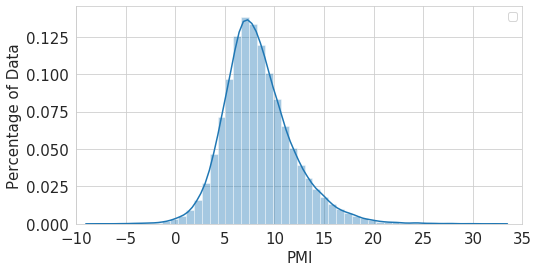

In [39]:
def apply_default_style(ax):
  ax.set_xlim([-10, 35])
  ax.set_xlabel("PMI")
  plt.tick_params(top=False, right=False, bottom=False, left=False)
  handles, labels = ax.get_legend_handles_labels()
  plt.legend('')
  

FONTSIZE = 15 
sns.set_style("whitegrid")
plt.rcParams.update({'axes.labelsize': FONTSIZE,
                     'xtick.labelsize': FONTSIZE,
                     'ytick.labelsize': FONTSIZE,
                     'legend.fontsize': 11})
plt.figure(figsize=(8, 4))
ax = sns.distplot(PMI_list);
apply_default_style(ax)
ax.set_ylabel("Percentage of Data");

plt.savefig("Audio_Textual_PMI_Dist.png", bbox_inches='tight')

In [28]:
sum(PMI_list)/len(PMI_list)

8.36868481433309

In [41]:
PMI_list[0:100]

array([-7.6992726 , -6.7807965 , -5.6266427 , -5.481501  , -5.224794  ,
       -5.146416  , -4.579079  , -4.4027123 , -4.305056  , -4.2590337 ,
       -4.1551843 , -4.1382203 , -4.0186896 , -3.8949914 , -3.8697543 ,
       -3.5772862 , -3.5459905 , -3.4639688 , -3.437162  , -3.2773232 ,
       -3.272038  , -3.2537942 , -3.0980363 , -3.090465  , -2.8501477 ,
       -2.8098016 , -2.7841496 , -2.7216592 , -2.678739  , -2.5881753 ,
       -2.5386796 , -2.5155225 , -2.5120301 , -2.5024962 , -2.4231896 ,
       -2.283009  , -2.2604146 , -2.2578511 , -2.19636   , -2.131474  ,
       -2.1276383 , -2.0115895 , -1.973495  , -1.8853593 , -1.800652  ,
       -1.7095299 , -1.6893663 , -1.6805634 , -1.6181016 , -1.587357  ,
       -1.5557361 , -1.5117593 , -1.5029054 , -1.4514589 , -1.4445605 ,
       -1.4325714 , -1.4154553 , -1.4049115 , -1.3884258 , -1.3728642 ,
       -1.241468  , -1.2269292 , -1.214746  , -1.1768932 , -1.1529212 ,
       -1.1387486 , -1.1348205 , -1.1333499 , -1.1141429 , -1.07

In [30]:
PMI_list

array([-7.6992726, -6.7807965, -5.6266427, ..., 30.022285 , 30.345135 ,
       32.16418  ], dtype=float32)

In [40]:
word_list[0:100]

array(['unbound', 'ronin', 'leath', 'seasonably', 'faria', 'informer',
       'judicially', 'embroiled', 'modestine', 'cloven', 'frighted',
       'registry', 'pullet', 'campan', 'buckley', 'technicians',
       'stallings', 'orang', 'semen', 'aristides', 'sighting',
       "student's", 'batted', 'pave', 'distantly', 'postulates',
       'chickie', 'instants', 'fosters', 'furlong', 'beginner',
       'dilatory', 'boreal', 'operatic', 'disan', 'tain', 'dwelled',
       'inheriting', 'enforces', 'barnes', 'adieux', 'maligned',
       'detaching', 'imaginatively', 'bungled', 'centurion', 'cleric',
       'gravest', 'pleader', 'chequered', 'someway', 'crates', "aven't",
       'electra', 'untruthfulness', 'irresolutely', 'bouchet', 'mete',
       'undetermined', 'swaggered', 'mens', 'everlastingly', 'surrenders',
       'comport', 'barchester', 'mistakenly', 'successions', 'cottons',
       'fannicot', 'overrated', 'contrives', 'adieus', 'pensioners',
       'bayside', 'uncourteous', 'bapt